Air delays - network anaylsis. which flights are more delayed than normal?  Are there certain routes that experience more delays than normal? Certain airports/airlines that experience more than average delays? network graph of delays between airports

https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr

For this project I will be perfroming a network analysis on airline delay data. This will be a weighted network graph and will examine the routes that have the highest delays to determine key nodes in delay patterns. Each type of delay will have it's own network graph to determine if there are overlapping nodes. Furthermore, a second network will be constructed from propogated delays, meaning the inital flight was delayed so other routes that plane took may also be delayed. Through this network, key nodes that assisted with the propogation or were able to break the delay chain can be identified.  

In [175]:
!pip install airportsdata
!pip install geopandas

In [238]:
#Step one, downloads and imports
import pandas as pd
from datetime import datetime
import networkx as nx
import airportsdata
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [62]:
#Step 2 import the data into a pandas dataframe
df = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_6.csv')
df.head() #examine the dataset

C:\Users\abiga\AppData\Local\Temp\ipykernel_25752\1363336085.py:2: DtypeWarning: Columns (77,84,85,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_6.csv')


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2025,2,6,1,7,2025-06-01,AA,19805,AA,N106NN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,2,6,2,1,2025-06-02,AA,19805,AA,N109NN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025,2,6,3,2,2025-06-03,AA,19805,AA,N102NN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025,2,6,4,3,2025-06-04,AA,19805,AA,N117AN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025,2,6,5,4,2025-06-05,AA,19805,AA,N102NN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df['CarrierDelay']

0         NaN
1         NaN
2         3.0
3         NaN
4         NaN
         ... 
611570    NaN
611571    NaN
611572    NaN
611573    NaN
611574    NaN
Name: CarrierDelay, Length: 611575, dtype: float64

In [475]:
#This is a nested dictionary object that contains information about airports
iata_airports = airportsdata.load('IATA') # key is the IATA location code
print(iata_airports['JFK'])

{'icao': 'KJFK', 'iata': 'JFK', 'name': 'John F Kennedy International Airport', 'city': 'New York', 'subd': 'New York', 'country': 'US', 'elevation': 13.0, 'lat': 40.63993, 'lon': -73.77869, 'tz': 'America/New_York', 'lid': 'JFK'}


In [473]:
#gets us a list of united states airports
us_airport_codes = [
    code
    for code, data in iata_airports.items()
    if data.get('country') == 'US'
]

In [87]:
#Step 3 clean the data
#There are a lot of columns here that I am not interested in
#3a. filter down to just the columns I am interested in

#To answer my question I need columns that identify the airline, the flight, the date, the destination, the origin and the type of delay
airData = df[['FlightDate', 'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
              'Origin', 'OriginCityName', 'OriginCityMarketID', 'DepDelay', 
              'Dest', 'DestCityName', 'DestCityMarketID', 'ArrDelay',
              'Flights', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].copy()
#I want to rename some of them
airData.rename(columns = {'DOT_ID_Reporting_Airline':'DOT_ID', 'IATA_CODE_Reporting_Airline':'IATA_Code'}, inplace=True)

airData.head()         

,FlightDate,DOT_ID,IATA_Code,Tail_Number,Origin,OriginCityName,OriginCityMarketID,DepDelay,Dest,DestCityName,DestCityMarketID,ArrDelay,Flights,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2025-06-01,19805,AA,N106NN,JFK,"New York, NY",31703,-11.0,LAX,"Los Angeles, CA",32575,-45.0,1.0,NaN,NaN,NaN,NaN,NaN
1,2025-06-02,19805,AA,N109NN,JFK,"New York, NY",31703,-8.0,LAX,"Los Angeles, CA",32575,-58.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2025-06-03,19805,AA,N102NN,JFK,"New York, NY",31703,28.0,LAX,"Los Angeles, CA",32575,15.0,1.0,3.0,0.0,0.0,0.0,12.0
3,2025-06-04,19805,AA,N117AN,JFK,"New York, NY",31703,-2.0,LAX,"Los Angeles, CA",32575,-4.0,1.0,NaN,NaN,NaN,NaN,NaN
4,2025-06-05,19805,AA,N102NN,JFK,"New York, NY",31703,-6.0,LAX,"Los Angeles, CA",32575,-4.0,1.0,NaN,NaN,NaN,NaN,NaN


In [481]:
#3b. Now that columns have been selected, the rows need to be filtered for the data wanted. 
#Right now, the dataframe contains data from every single flight during the month of June. I only want the delayed flights
# Filter rows where both Origin and Dest are in the US airport codes
usAirData = airData[
    airData['Origin'].isin(us_airport_codes) & 
    airData['Dest'].isin(us_airport_codes)
]

#Flights that arrived late at the gate will have a positive number in the ArrDelay column
delayed = usAirData[usAirData.ArrDelay>0]
firstDelayed = delayed[:50] #I am taking a small chuck to begin with 

In [483]:
#Officially delayed flights are flights that have been delayed by over 15 min 
officialDelay = usAirData[usAirData.ArrDelay>= 15]
officialDelay.head()

,FlightDate,DOT_ID,IATA_Code,Tail_Number,Origin,OriginCityName,OriginCityMarketID,DepDelay,Dest,DestCityName,DestCityMarketID,ArrDelay,Flights,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2,2025-06-03,19805,AA,N102NN,JFK,"New York, NY",31703,28.0,LAX,"Los Angeles, CA",32575,15.0,1.0,3.0,0.0,0.0,0.0,12.0
9,2025-06-10,19805,AA,N106NN,JFK,"New York, NY",31703,167.0,LAX,"Los Angeles, CA",32575,201.0,1.0,0.0,0.0,201.0,0.0,0.0
55,2025-06-26,19805,AA,N103NN,LAX,"Los Angeles, CA",32575,-4.0,JFK,"New York, NY",31703,17.0,1.0,0.0,0.0,17.0,0.0,0.0
61,2025-06-02,19805,AA,N117AN,JFK,"New York, NY",31703,664.0,LAX,"Los Angeles, CA",32575,684.0,1.0,0.0,0.0,28.0,0.0,656.0
65,2025-06-06,19805,AA,N109NN,JFK,"New York, NY",31703,187.0,LAX,"Los Angeles, CA",32575,220.0,1.0,187.0,0.0,33.0,0.0,0.0


In [ ]:
#might also want to create a new column of dataframes with just the specific delay type
carrierDelay = officialDelay[officialDelay.CarrierDelay>0]


Step 4 is building the network graph. I will start off with the slice and then move to all of the delayed flights. First I am making a list of the edges, with one node being origin and the other being destination

In [485]:
#Set the edges to an array of origin and destination from only the officially delayed flights
edges = officialDelay[['Origin', 'Dest']].values

In [487]:
#Now to graph it
G = nx.from_edgelist(edges)

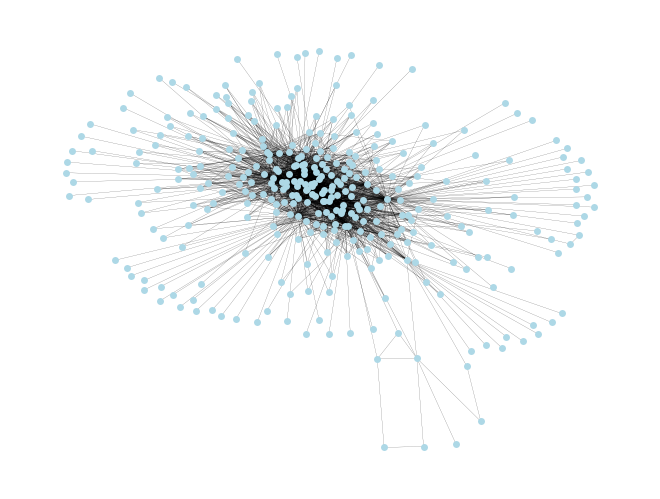

In [489]:
#Graphing options
options = { 'node_color': 'lightblue',
            'node_size': 25,
             'linewidths': 0,
            'width': 0.1,
            'with_labels': False}
#And the preliminary graph, without any weighting or anything
nx.draw(G, **options)

Now I am going to work on mapping it to the US. I found a package called pygris, which automatically loads in the US census beauru catrographic maps. It has a module to resccale.  

In [264]:
!pip install pygris

Using the default year of 2024


<Axes: >

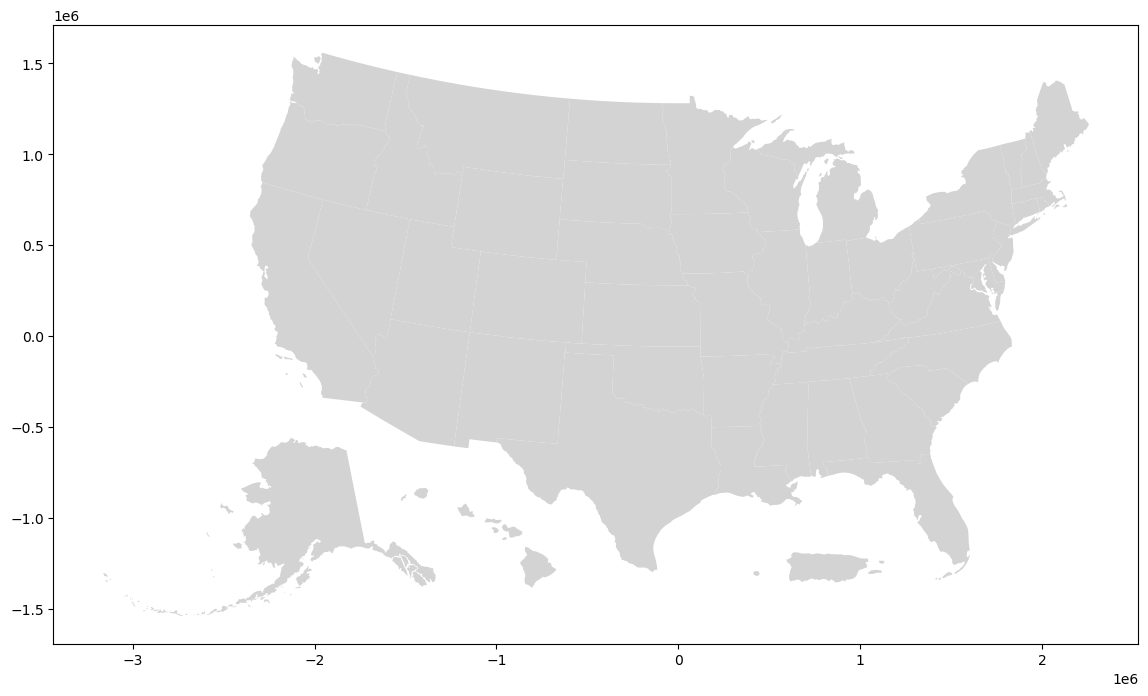

In [351]:
import pygris
from pygris.utils import shift_geometry
import matplotlib.pyplot as plt

states = pygris.states(cb=True, resolution = "20m")  # cartographic boundary file
states = states.to_crs("EPSG:2163")
fig, ax = plt.subplots(figsize=(14, 10))
states_rescaled = shift_geometry(states)
states_rescaled.plot(ax=ax, color='lightgrey')

Now I am going to pull out the latitude and longitude for each airport so the network can be plotted on the US map. airportsdata is a dictrionary of all the airports with the latitude and longitude of each airport. 

In [491]:
#removing any unnessesary information from the airport dictionaries
remove_keys = {'icao', 'iata', 'name', 'city', 'subd', 'country', 'elevation', 'tz', 'lid'}

airports = {
    code: {k: v for k, v in data.items() if k not in remove_keys}
    for code, data in iata_airports.items()
}

In [493]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:2163", always_xy=True)

pos_projected = {
    code: transformer.transform(lon, lat)
    for code, (lon, lat) in pos.items()
}


In [495]:
deg = nx.degree(G)
sizes = [5 * deg[iata] for iata in G.nodes]

In [497]:
labels = {iata: iata if deg[iata] >= 20 else ''
          for iata in G.nodes}

In [499]:
from pyproj import Transformer

# Map is in EPSG:2163, airports are in EPSG:4326
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2163", always_xy=True)

pos_projected = {
    code: transformer.transform(lon, lat)
    for code, (lon, lat) in pos.items()
}


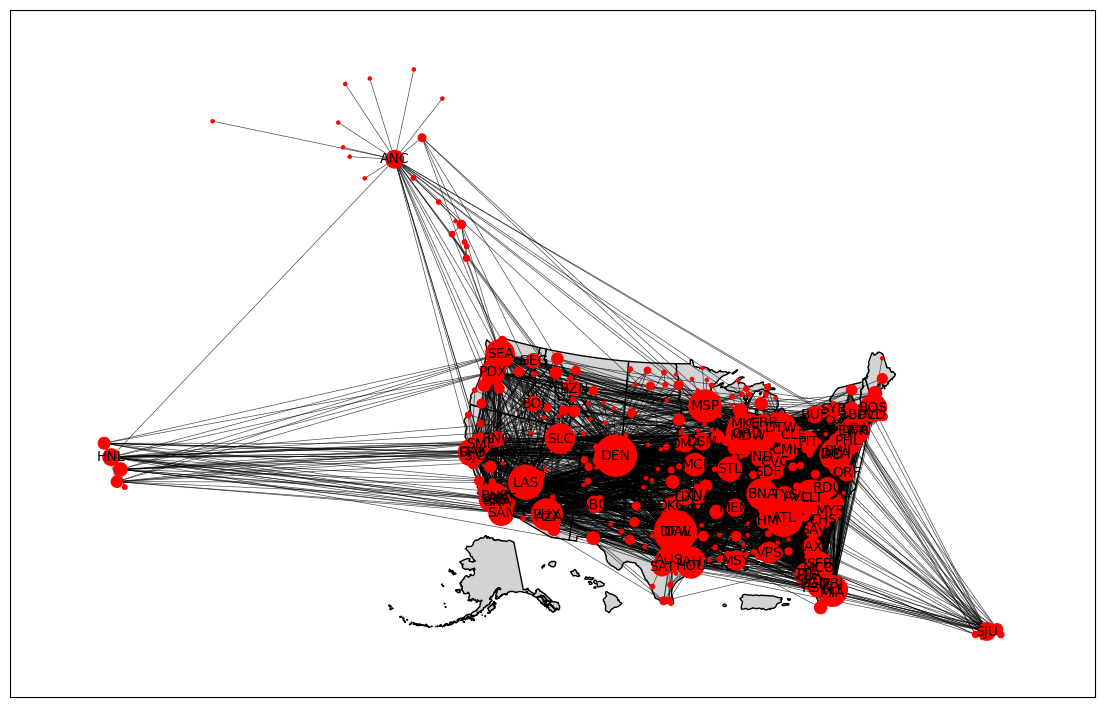

In [501]:
import matplotlib.pyplot as plt
import networkx as nx
from pyproj import Transformer

fig, ax = plt.subplots(figsize=(14, 10))

# 2. Plot the states on that axes
states_rescaled.plot(ax=ax, color='lightgrey', edgecolor='black')

# 3. Project airport coordinates to match the map CRS
transformer = Transformer.from_crs("EPSG:4326", states_rescaled.crs, always_xy=True)
pos_projected = {code: transformer.transform(lon, lat) for code, (lon, lat) in pos.items()}

# 4. Draw NetworkX graph on the same axes
nx.draw_networkx_nodes(G, pos=pos_projected, ax=ax, node_size=sizes, node_color='red')
nx.draw_networkx_edges(G, pos=pos_projected, ax=ax, width=0.5, alpha=0.7)

#labels 
nx.draw_networkx_labels(
    G,
    pos=pos_projected,
    ax=ax,
    labels=labels,       # dictionary {node: label}
    font_size=10,
    font_color='black'
)
# 5. Ensure figure renders in Jupyter
plt.show()


Using the default year of 2024


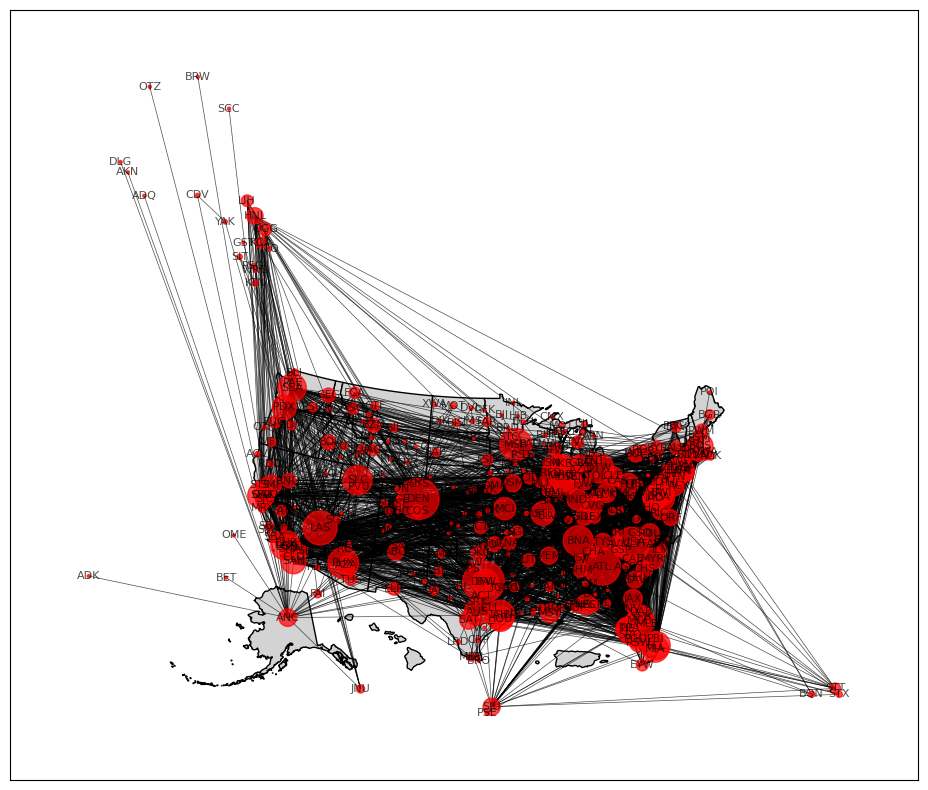

In [511]:
import matplotlib.pyplot as plt
import networkx as nx
from pyproj import Transformer
from shapely.geometry import Point
from shapely.affinity import translate

# --- 1. Create figure and axes ---
fig, ax = plt.subplots(figsize=(14, 10))

# --- 2. Rescaled US states ---
states = pygris.states(cb=True, resolution="20m").to_crs("EPSG:2163")
states_rescaled = shift_geometry(states)
states_rescaled.plot(ax=ax, color='lightgrey', edgecolor='black')

# --- 3. Project airport coordinates to match map CRS ---
# pos = {IATA_code: (lon, lat)}  # your original lon/lat dictionary
transformer = Transformer.from_crs("EPSG:4326", states_rescaled.crs, always_xy=True)
pos_projected = {code: transformer.transform(lon, lat) for code, (lon, lat) in pos.items()}

# --- 4. Convert to Shapely Points ---
airport_points = {code: Point(x, y) for code, (x, y) in pos_projected.items()}

# --- 5. Identify special region airports ---
alaska_airports = ['ANC', 'FAI', 'JNU', 'ADK', 'OME', 'BET']   # example IATA codes
hawaii_airports = ['HNL', 'OGG', 'KOA', 'LIH', 'ITO']
puerto_rico_airports = ['SJU', 'PSE']

# --- 6. Compute map bounds for relative placement ---
minx, miny, maxx, maxy = states_rescaled.total_bounds
width = maxx - minx
height = maxy - miny

# Relative offsets (tweak multipliers if needed)
alaska_offset = (0.2*width, -1.4*height)       # move Alaska upper-left
hawaii_offset = (0.7*width, 0.9*height)      # move Hawaii lower-middle
puerto_rico_offset = (-.6*width, -0.05*height) # move Puerto Rico lower-right

# --- 7. Apply offsets using Shapely ---
airport_points_adjusted = {}
for code, point in airport_points.items():
    if code in alaska_airports:
        airport_points_adjusted[code] = translate(point, xoff=alaska_offset[0], yoff=alaska_offset[1])
    elif code in hawaii_airports:
        airport_points_adjusted[code] = translate(point, xoff=hawaii_offset[0], yoff=hawaii_offset[1])
    elif code in puerto_rico_airports:
        airport_points_adjusted[code] = translate(point, xoff=puerto_rico_offset[0], yoff=puerto_rico_offset[1])
    else:
        airport_points_adjusted[code] = point

# --- 8. Convert back to tuples for NetworkX ---
pos_adjusted = {code: (point.x, point.y) for code, point in airport_points_adjusted.items()}

# --- 9. Draw NetworkX graph ---
nx.draw_networkx(
    G,
    pos=pos_adjusted,
    ax=ax,
    node_size=sizes,
    node_color='red',
    width=0.5,
    alpha=0.7,
    with_labels = True,  # {node: label} dictionary
    font_size=8
)

plt.show()
